# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [21]:
X_train = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [22]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [23]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [24]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [25]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [26]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [27]:
# Ваш код здесь
pca = PCA(random_state=RANDOM_STATE)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [28]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print(f"Количество компонент для 90% дисперсии: {pca.n_components_}")

Количество компонент для 90% дисперсии: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [29]:
# Ваш код здесь
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)
print(f"Доля дисперсии первой компоненты: {pca_full.explained_variance_ratio_[0]:.0%}")

Доля дисперсии первой компоненты: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

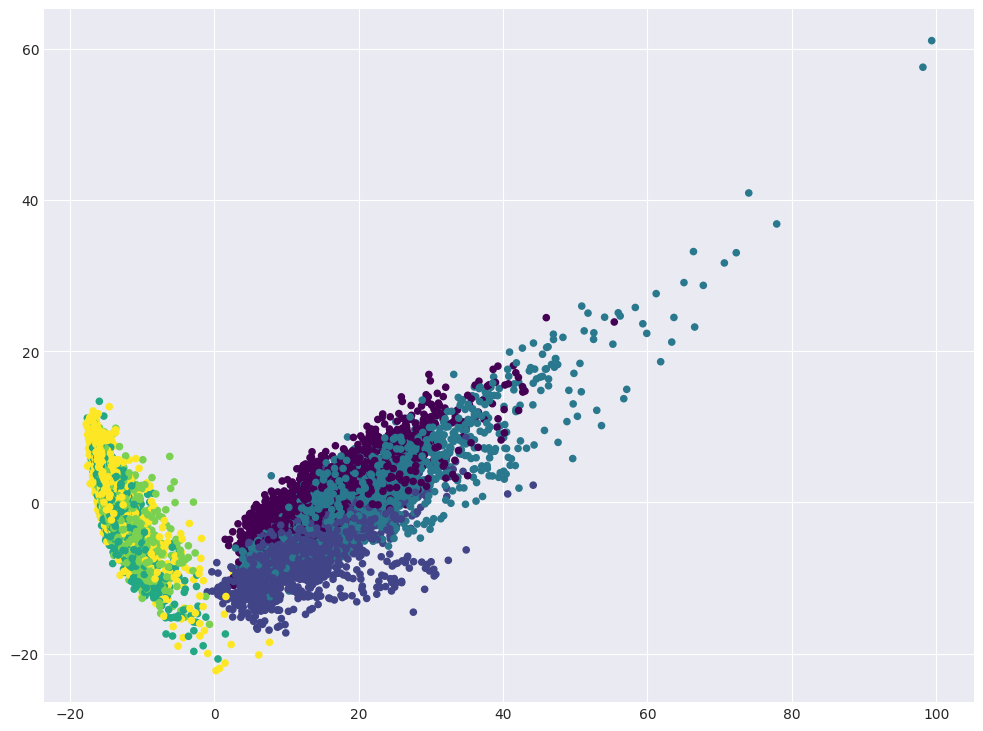

In [30]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [ ]:
# Ваш код здесь
from sklearn.cluster import KMeans

kmeans_sklearn = KMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)
kmeans_sklearn.fit(X_pca)
cluster_labels_sklearn = kmeans_sklearn.labels_

class MyKMeans:
    def __init__(self, n_clusters, n_init=100, random_state=None, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        best_inertia = float('inf')
        best_centers = None
        best_labels = None

        for init in range(self.n_init):
            indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            centers = X[indices].copy()

            for iteration in range(self.max_iter):
                distances = np.sqrt(((X[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
                labels = np.argmin(distances, axis=1)

                new_centers = np.array([
                    X[labels == i].mean(axis=0) if np.sum(labels == i) > 0
                    else centers[i] for i in range(self.n_clusters)
                ])

                if np.all(np.abs(new_centers - centers) < self.tol):
                    centers = new_centers
                    break

                centers = new_centers

            inertia = np.sum((X - centers[labels]) ** 2)

            if inertia < best_inertia:
                best_inertia = inertia
                best_centers = centers
                best_labels = labels

        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia

        return self

kmeans_custom = MyKMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE,
    max_iter=300,
    tol=1e-4
)
kmeans_custom.fit(X_pca)
cluster_labels_custom = kmeans_custom.labels_

print(f"Inertia sklearn: {kmeans_sklearn.inertia_:.2f}")
print(f"Inertia custom: {kmeans_custom.inertia_:.2f}")
from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(cluster_labels_sklearn, cluster_labels_custom)
print(f"Adjusted Rand Index между реализациями: {ari_score:.4f}")


Inertia sklearn: 2003454.90
Inertia custom: 2003454.20
Adjusted Rand Index между реализациями: 0.9987


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

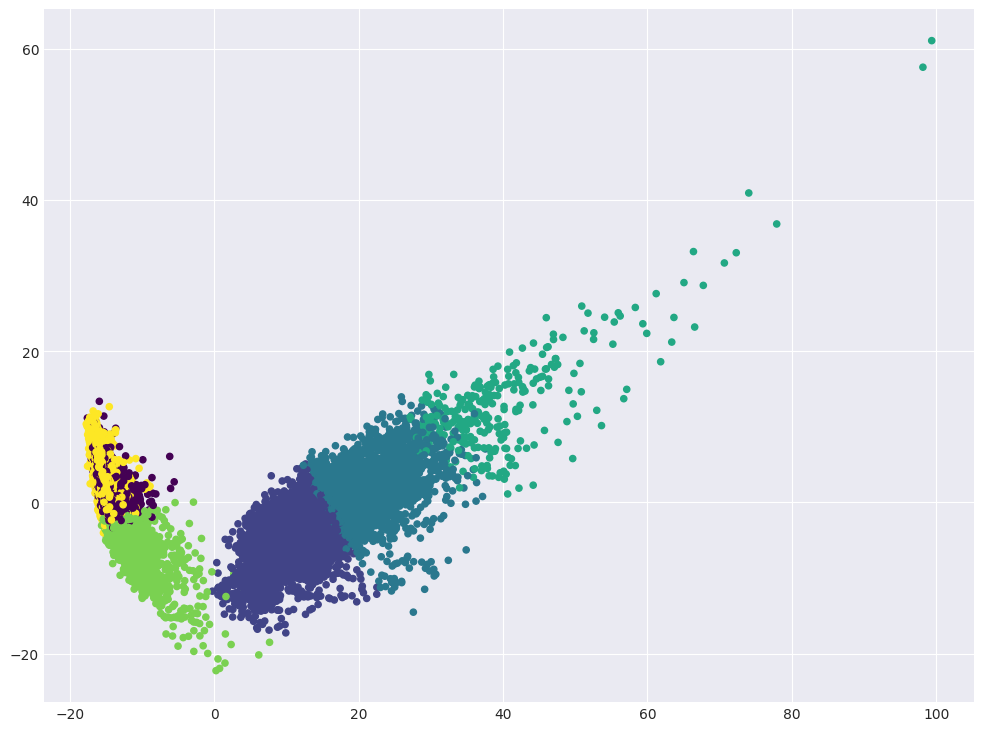

In [32]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_sklearn, s=20, cmap='viridis')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [33]:
tab = pd.crosstab(y, cluster_labels_sklearn, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


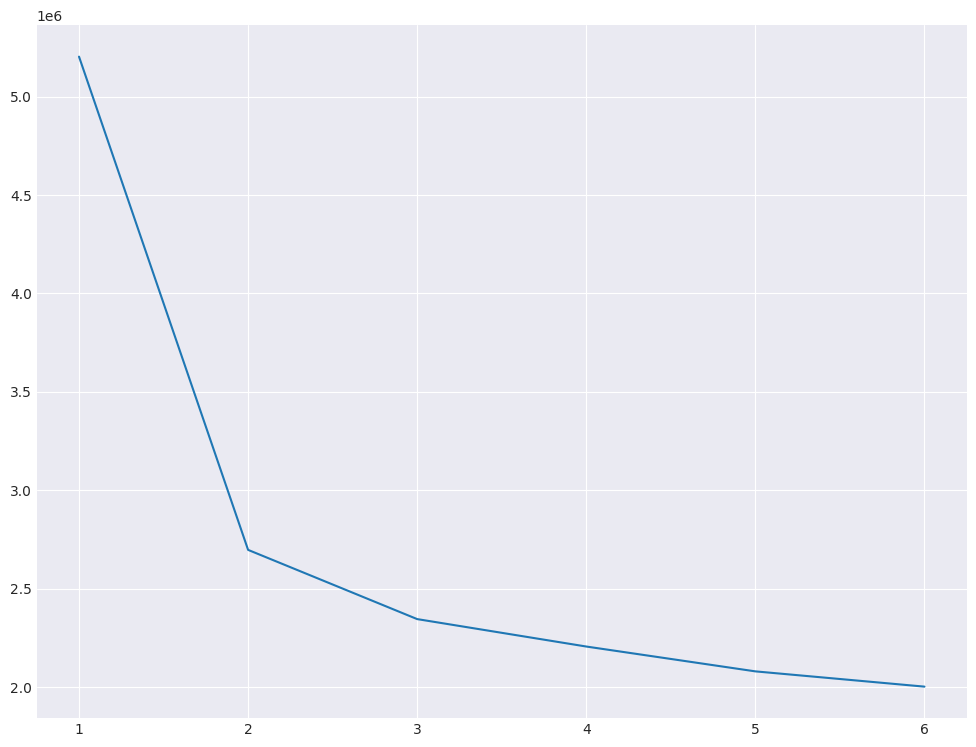

In [38]:
# Ваш код здесь
from tqdm import tqdm
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, n_classes + 1), inertia)
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [39]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [40]:
# Ваш код здесь
from sklearn.metrics import adjusted_rand_score

ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)
ari_kmeans = adjusted_rand_score(y, cluster_labels_sklearn)
ari_ag = adjusted_rand_score(y, ag.labels_)

print(f"ARI KMeans: {ari_kmeans:.3f}")
print(f"ARI Agglomerative: {ari_ag:.3f}")

ARI KMeans: 0.420
ARI Agglomerative: 0.494


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [42]:
# Ваш код здесь
scaler2 = StandardScaler()
X_train_scaled = scaler2.fit_transform(X_train)
X_test_scaled = scaler2.transform(X_test)

In [48]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [49]:
# Ваш код здесь
grid_search = GridSearchCV(svc, svc_params, cv=3)
grid_search.fit(X_train_scaled, y_train)

,estimator,LinearSVC(max...ndom_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [50]:
# Ваш код здесь
best_svc = grid_search.best_estimator_
print(f"Best C: {grid_search.best_params_}")

Best C: {'C': 0.1}


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [51]:
y_predicted = best_svc.predict(X_test_scaled)

In [52]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

__Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.__

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

In [54]:
pca2 = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca2.fit_transform(X_train_scaled)
X_test_pca = pca2.transform(X_test_scaled)

grid_search_pca = GridSearchCV(svc, svc_params, cv=3)
grid_search_pca.fit(X_train_pca, y_train)

print(f"Best score without PCA: {grid_search.best_score_:.3f}")
print(f"Best score with PCA: {grid_search_pca.best_score_:.3f}")
print(f"Difference: {(grid_search.best_score_ - grid_search_pca.best_score_)*100:.0f}%")

Best score without PCA: 0.938
Best score with PCA: 0.898
Difference: 4%


**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

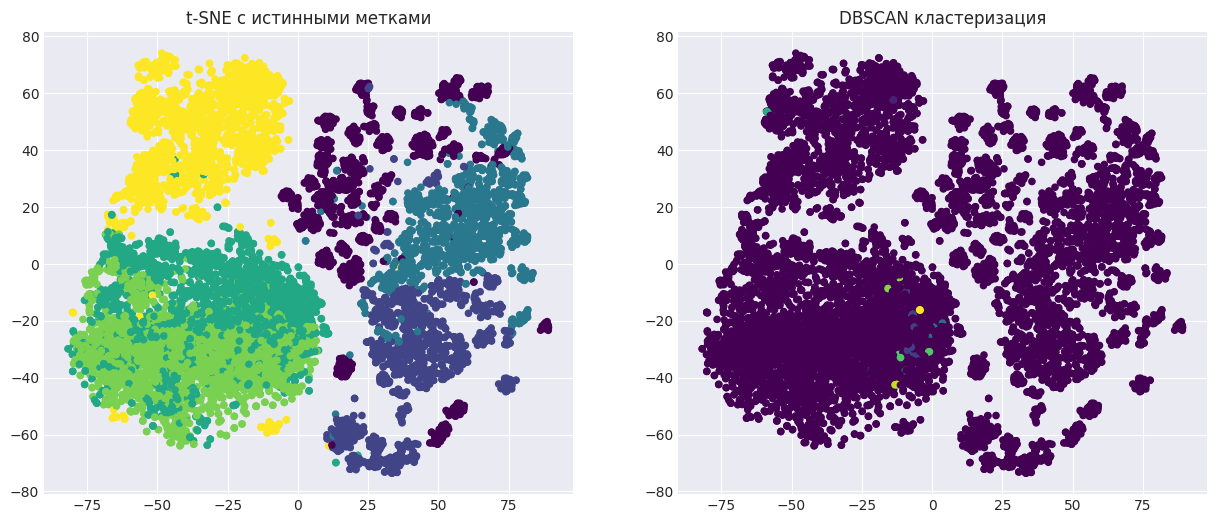

Количество кластеров DBSCAN: 11
Шумовые точки: 10220


In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca[:, :50])

dbscan = DBSCAN(eps=5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca[:, :50])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis')
ax1.set_title('t-SNE с истинными метками')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=20, cmap='viridis')
ax2.set_title('DBSCAN кластеризация')
plt.show()

print(f"Количество кластеров DBSCAN: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Шумовые точки: {sum(dbscan_labels == -1)}")